<a href="https://colab.research.google.com/github/ambgeo/Youtube/blob/main/02_Flood_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##Instalar pacote
!pip install rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.6 MB/s eta 0:00:00


In [25]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors as mcolors


In [36]:
# Caminho para sua imagem
image_path = '/content/drive/MyDrive/GEE_Exports/S2_POA_2024.tif'  # Atualize para seu caminho!

# Abrir a imagem
src = rasterio.open(image_path)

# Ver informações da imagem
print(src.profile)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 6459, 'height': 3525, 'count': 11, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.983152841195215e-05, 0.0, -51.692744540902154,
       0.0, -8.983152841195215e-05, -29.762622667334337), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


Para calcular o NDWI clássico (McFeeters, 1996):

Baixar dados em https://code.earthengine.google.com/4fd9cea94b7feace76804b4ecad2c582

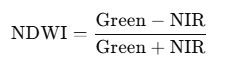

In [37]:
# Ler a banda Verde (Green)
green = src.read(3)

# Ler a banda Infravermelho Próximo (NIR)
nir = src.read(8)


In [38]:
# Calcular NDWI
ndwi = (green.astype(float) - nir.astype(float)) / (green + nir)

# Substituir NaNs (divisão por zero)
ndwi = np.nan_to_num(ndwi)

# Ver valores mínimo e máximo do NDWI
print("NDWI mínimo:", ndwi.min())
print("NDWI máximo:", ndwi.max())


NDWI mínimo: -1.0
NDWI máximo: 0.8710759738567991


In [39]:
# Criar a máscara de água
water_mask = ndwi > 0.0

# Mostrar quantos pixels foram detectados como água
print("Pixels de água detectados:", np.sum(water_mask))


Pixels de água detectados: 4779678


In [40]:
# Preparar o perfil de salvamento
profile = src.profile
profile.update(
    dtype=rasterio.uint8,  # máscara binária (0 e 1)
    count=1
)

# Definir o caminho para salvar
water_mask_output_path = 'water_mask.tif'  # Atualize!

# Salvar
with rasterio.open(water_mask_output_path, 'w', **profile) as dst:
    dst.write(water_mask.astype(rasterio.uint8), 1)

print(f"Máscara de água salva em: {water_mask_output_path}")


Máscara de água salva em: water_mask.tif


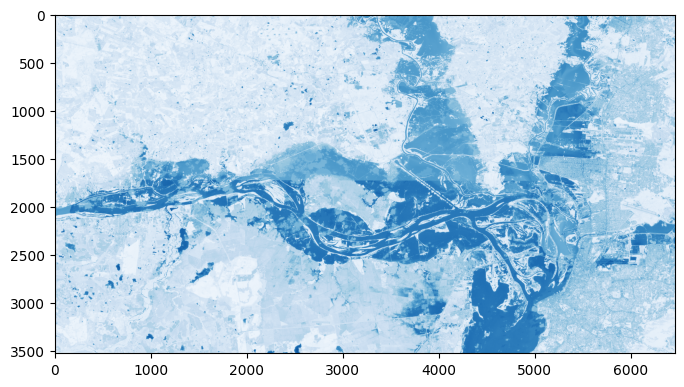

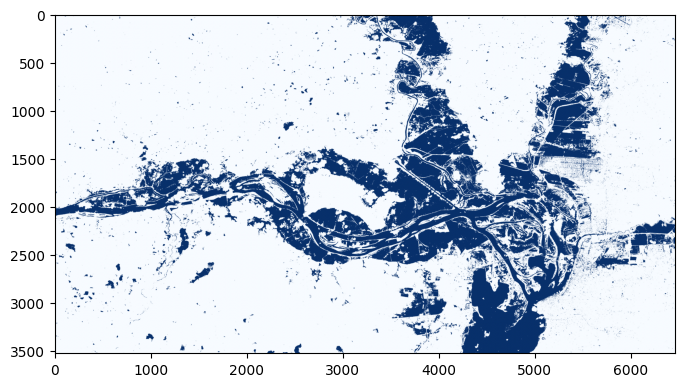

In [41]:
# Plotar NDWI
plt.figure(figsize=(8, 6))
show(ndwi, cmap='Blues', vmin=-1, vmax=1)
plt.show()

# Abrir a máscara de água salva
water_mask_src = rasterio.open(water_mask_output_path)
water_mask_data = water_mask_src.read(1)

# Plotar Máscara de Água
plt.figure(figsize=(8, 6))
show(water_mask_data, cmap='Blues')
plt.show()


In [44]:
# Ler as bandas RGB (Red, Green, Blue)
red = src.read(3)
green = src.read(2)
blue = src.read(1)

# Montar o array RGB (normalizar para ficar mais bonito)
rgb = np.stack([red, green, blue], axis=0)

# Normalizar para [0,1] para visualização
rgb_norm = np.clip(rgb / np.percentile(rgb, 98), 0, 1)


In [45]:
# Se você ainda não tiver, carregue a máscara de água
water_mask_src = rasterio.open(water_mask_output_path)
water_mask_data = water_mask_src.read(1)


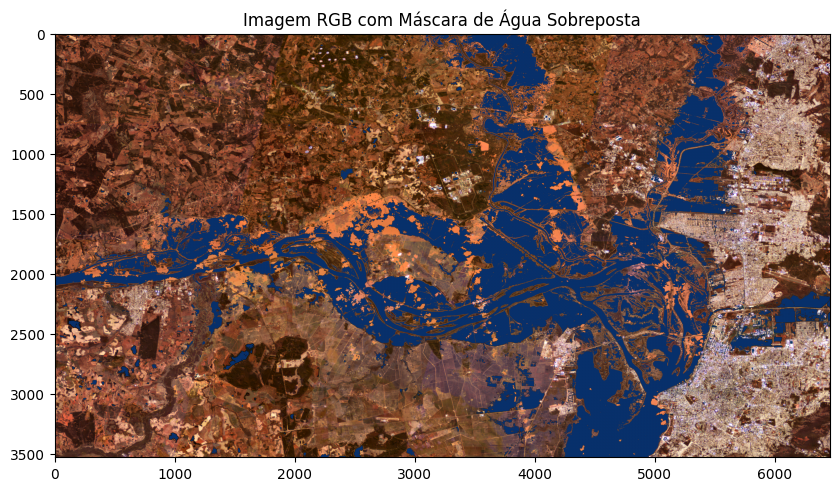

In [47]:
# Preparar a figura
fig, ax = plt.subplots(figsize=(10, 10))

# Mostrar o RGB
show(rgb_norm, ax=ax)
ax.set_title('Imagem RGB com Máscara de Água Sobreposta')

# Sobrepor a máscara de água
# Vamos usar uma máscara azul semi-transparente
# Onde water_mask_data == 1, desenhamos
masked_water = np.ma.masked_where(water_mask_data == 0, water_mask_data)

# Plotar a máscara em azul
ax.imshow(masked_water, cmap='Blues', alpha=1, vmin=0.2, vmax=1)  # alpha controla a transparência

plt.show()
